In [14]:
import requests, bs4

from bs4 import BeautifulSoup as bs

import pandas as pd 
import numpy as np
import re, os

import statsmodels.api as sm
import statsmodels.formula.api as smf
import patsy

import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Lasso, LassoCV, Ridge, RidgeCV, ElasticNet, ElasticNetCV
from sklearn.metrics import r2_score

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import lars_path
%matplotlib inline

In [2]:
def findTables(url):
    res = requests.get(url)
    ## comments break parsing.  Next 2 comments fix that
    comm = re.compile("<!--|-->")
    soup = bs4.BeautifulSoup(comm.sub("", res.text), 'lxml')
    divs = soup.findAll('div', id = "content")
    divs = divs[0].findAll("div", id=re.compile("^all"))
    ids = []
    for div in divs:
        searchme = str(div.findAll("table"))
        x = searchme[searchme.find("id=") + 3: searchme.find(">")]
        x = x.replace("\"", "")
        if len(x) > 0:
            ids.append(x)
    return(ids)

def pullTable(url, tableID):
    res = requests.get(url)
    ## Work around comments
    comm = re.compile("<!--|-->")
    soup = bs4.BeautifulSoup(comm.sub("", res.text))
    tables = soup.findAll('table', id = tableID)
    data_rows = tables[0].findAll('tr')
    data_header = tables[0].findAll('thead')
    data_header = data_header[0].findAll("tr")
    data_header = data_header[0].findAll("th")
    game_data = [[td.getText() for td in data_rows[i].findAll(['th','td'])]
        for i in range(len(data_rows))
        ]
    data = pd.DataFrame(game_data)
    header = []
    for i in range(len(data.columns)):
        header.append(data_header[i].getText())
    data.columns = header
    data = data.loc[data[header[0]] != header[0]]
    data = data.reset_index(drop = True)
    return(data)

def Get_Batting_Stats(batter_df):
    df_dict={}
    for i in range(0, len(batter_df)):
        url = batter_df['URL'][i]
        batter_data = pullTable(url, "batting_standard")
        time.sleep(3)
        df_dict[batter_df['Player'][i]] = batter_data
        
    return df_dict

def Get_Adv_Batting_Stats(batter_df):
    df_dict={}
    for i in range(0, len(batter_df)):
        url = batter_df['URL'][i]
        batter_data = pullTable(url, "batting_advanced")
        time.sleep(3)
        df_dict[batter_df['Player'][i]] = batter_data
        
    return df_dict


def Get_Pitching_Stats(pitcher_df):
    df_dict={}
    for i in range(0, len(pitcher_df)):
        url = pitcher_df['URL'][i]
        pitcher_data = pullTable(url, "pitching_standard")
        time.sleep(3)
        df_dict[pitcher_df['Player'][i]] = pitcher_data
        
    return df_dict

# checks if player is a position player and under FA contract
def eligibility(url):
    res = requests.get(url)
    page = res.text
    soup = bs(page)
    meta = soup.find('div', id='meta').text
    
    position_loc = meta.find('Position')
    position = meta[position_loc:position_loc+25]
    
    time.sleep(3)
    
    if position.find('itcher') == -1:
        pos_result = True
    else:
        return False
    
    contract_loc = meta.find('2022 Contract Status')
    contract = meta[contract_loc:contract_loc+64]
    
    if contract.find('Signed') == -1:
        return False
    else:
        return contract

def contract_start(contract):
    contract = meta[contract_loc:contract_loc+64]
    listed =  re.findall('\w+',contract)
    origin_list = [i for i, elem in enumerate(listed) if 'yr' in elem]
    origin = origin_list[0]
    
    if 'M' in listed[origin+1]:
        con_start = '20'+ listed[origin+2]
        con_start = int(con_start)
    else:
        con_start = '20'+ listed[origin+3]
        con_start = int(con_start)
    
    avg = total/length
    
    return con_start

def contract_avg(contract):
    contract = meta[contract_loc:contract_loc+64]
    listed =  re.findall('\w+',contract)
    origin_list = [i for i, elem in enumerate(listed) if 'yr' in elem]
    origin = origin_list[0]
    
    length = int(listed[origin-1])
    
    if 'M' in listed[origin+1]:
        total = int(listed[origin+1].replace('M',''))
    else:
        total = listed[origin+1]+'.'+listed[origin+2]
        total = total.replace('M','')
        total = float(total)
        
    avg = total/length
    return avg

In [18]:
'''
# ari test list

player_list = pd.DataFrame(columns=['Player', 'URL'])

url = 'https://www.baseball-reference.com/teams/ARI/2021.shtml'
res = requests.get(url)
page = res.text
soup = bs(page)
table = soup.find(id = 'team_batting')
links = table.findAll('a')

for tag in links:
    link = 'https://www.baseball-reference.com/' + tag['href']
    name = tag.text
    player_list = player_list.append({'Player': name,'URL':link},ignore_index=True)
    
player_list.to_csv('ari_test.csv', index=False)
    
'''

# grabs all links for all players who had an at bat in 2021

team_urls = ('https://www.baseball-reference.com/teams/ARI/2021.shtml',
             'https://www.baseball-reference.com/teams/ATL/2021.shtml', 
             'https://www.baseball-reference.com/teams/BAL/2021.shtml',
            'https://www.baseball-reference.com/teams/BOS/2021.shtml',
            'https://www.baseball-reference.com/teams/CHC/2021.shtml',
            'https://www.baseball-reference.com/teams/CHW/2021.shtml',
            'https://www.baseball-reference.com/teams/CIN/2021.shtml',
            'https://www.baseball-reference.com/teams/CLE/2021.shtml',
            'https://www.baseball-reference.com/teams/COL/2021.shtml',
            'https://www.baseball-reference.com/teams/DET/2021.shtml',
            'https://www.baseball-reference.com/teams/HOU/2021.shtml',
            'https://www.baseball-reference.com/teams/KCR/2021.shtml',
            'https://www.baseball-reference.com/teams/ANA/2021.shtml',
            'https://www.baseball-reference.com/teams/LAD/2021.shtml',
            'https://www.baseball-reference.com/teams/FLA/2021.shtml',
            'https://www.baseball-reference.com/teams/MIL/2021.shtml',
            'https://www.baseball-reference.com/teams/MIN/2021.shtml',
            'https://www.baseball-reference.com/teams/NYM/2021.shtml',
            'https://www.baseball-reference.com/teams/NYY/2021.shtml',
            'https://www.baseball-reference.com/teams/OAK/2021.shtml',
            'https://www.baseball-reference.com/teams/PHI/2021.shtml',
            'https://www.baseball-reference.com/teams/PIT/2021.shtml',
            'https://www.baseball-reference.com/teams/SDP/2021.shtml',
            'https://www.baseball-reference.com/teams/SFG/2021.shtml',
            'https://www.baseball-reference.com/teams/SEA/2021.shtml',
            'https://www.baseball-reference.com/teams/STL/2021.shtml',
            'https://www.baseball-reference.com/teams/TBD/2021.shtml',
            'https://www.baseball-reference.com/teams/TEX/2021.shtml',
            'https://www.baseball-reference.com/teams/TOR/2021.shtml',
            'https://www.baseball-reference.com/teams/WSN/2021.shtml')

player_list = pd.DataFrame(columns=['Player', 'URL'])

for team in team_urls:
    res = requests.get(team)
    page = res.text
    soup = bs(page)
    time.sleep(3)
    links = soup.select('#team_batting a')
    
    for tag in links:
        link = 'https://www.baseball-reference.com/' + tag['href']
        name = tag.text
        player_list = player_list.append({'Player': name,'URL':link},ignore_index=True)

player_list = player_list.drop_duplicates(ignore_index=True)
player_list.to_csv('batter.csv', index=False)

In [ ]:
# test to find out if player is position player or pitcher
# scrape will take 2-3 hours to run.


eligible = []

for index, batter in player_list.iterrows():
    res = requests.get(batter['URL'])
    page = res.text
    soup = bs(page)
    meta = soup.find('div', id='meta').text
    time.sleep(3)
    
    position_loc = meta.find('Position')
    position = meta[position_loc+13:position_loc+25]
    
    contract_loc = meta.find('2022 Contract Status')
    
    if position.find('itcher') == -1:
        eligible.append(True)
    else:
        eligible.append(False)


In [ ]:
player_list['Eligible'] =  eligible
positional_list = player_list.loc[player_list['Eligible'], :]
positional_list.to_csv('positional.csv', index=False)

In [ ]:
# options for testing code
# batter_csv = pd.read_csv("ari_test.csv")
# batter_csv = pd.read_csv("batter.csv")
# batter_csv = pd.read_csv("signed.csv")

batter_csv = pd.read_csv("positional.csv")
batter_csv.tail()

In [4]:
# scrape to create dictionary of batting stats for each player

batter_dic = Get_Batting_Stats(batter_csv)

In [5]:
batter_dic['Miguel Cabrera'].head()

Year Age       Tm     Lg    G   PA   AB   R    H  2B  ...    OPS OPS+   TB  \
0  2000  17  FLA-min  Rk,A-   65  284  251  41   65  12  ...   .685        87   
1  2001  18  FLA-min      A  110  465  422  61  113  19  ...   .709       161   
2  2002  19  FLA-min     A+  124  545  489  77  134  43  ...   .754       206   
3  2003  20  FLA-min     AA   69  303  266  46   97  29  ...  1.038       162   
4  2003  20      FLA     NL   87  346  314  39   84  21  ...   .793  106  147   

  GDP HBP SH SF IBB   Pos               Awards  
0   7   6  0  2   0        MLN,UTI · GULF,NYPL  
1  10   2  1  3   2                 KNC · MIDW  
2  19   9  1  8   2                 JUP · FLOR  
3   8   2  0  4   7                 CAR · SOUL  
4  12   2  4  1   3  75/H         MVP-27,RoY-5  

[5 rows x 30 columns]

In [ ]:
# drop all minor league and total stats. Create master list for data

master_list = pd.DataFrame()

for player in batter_dic:
    major_time = []
    for row in range(len(batter_dic[player])):
        if batter_dic[player]['Lg'][row] == 'AL':
            major_time.append(True)
        elif batter_dic[player]['Lg'][row] == 'NL':
            major_time.append(True)
        else:
            major_time.append(False)
    batter_dic[player] = batter_dic[player].loc[major_time, :]
    batter_dic[player].drop(['Year','Tm','Lg','Pos','Awards'], axis=1, inplace=True)

    # append to master list
    master_list = master_list.append(batter_dic[player], ignore_index=True)

    
# create save file for master_list
# master_list.to_csv('master.csv', index=False)


In [3]:
# read in master_list to avoid scrape

master_list = pd.read_csv("master.csv")

In [4]:
master_list.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3365 entries, 0 to 3364
Data columns (total 25 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Age     3365 non-null   int64  
 1   G       3365 non-null   int64  
 2   PA      3365 non-null   int64  
 3   AB      3365 non-null   int64  
 4   R       3365 non-null   int64  
 5   H       3365 non-null   int64  
 6   2B      3365 non-null   int64  
 7   3B      3365 non-null   int64  
 8   HR      3365 non-null   int64  
 9   RBI     3365 non-null   int64  
 10  SB      3365 non-null   int64  
 11  CS      3365 non-null   int64  
 12  BB      3365 non-null   int64  
 13  SO      3365 non-null   int64  
 14  BA      3357 non-null   float64
 15  OBP     3358 non-null   float64
 16  SLG     3357 non-null   float64
 17  OPS     3357 non-null   float64
 18  OPS+    3357 non-null   float64
 19  TB      3365 non-null   int64  
 20  GDP     3365 non-null   int64  
 21  HBP     3365 non-null   int64  
 22  

In [5]:
master_list.corr()

Age         G        PA        AB         R         H        2B  \
Age   1.000000  0.072955  0.061845  0.056441  0.047360  0.043404  0.043584   
G     0.072955  1.000000  0.976315  0.976015  0.920620  0.948606  0.898240   
PA    0.061845  0.976315  1.000000  0.998204  0.961639  0.983079  0.933477   
AB    0.056441  0.976015  0.998204  1.000000  0.954071  0.984743  0.933098   
R     0.047360  0.920620  0.961639  0.954071  1.000000  0.962221  0.921935   
H     0.043404  0.948606  0.983079  0.984743  0.962221  1.000000  0.946761   
2B    0.043584  0.898240  0.933477  0.933098  0.921935  0.946761  1.000000   
3B   -0.108057  0.565582  0.575595  0.582083  0.572283  0.588303  0.531817   
HR    0.087625  0.767956  0.812469  0.801086  0.862723  0.799883  0.773029   
RBI   0.086016  0.890171  0.928219  0.922270  0.931376  0.926378  0.897544   
SB   -0.088120  0.501837  0.520855  0.524449  0.545314  0.535072  0.464907   
CS   -0.127146  0.555493  0.568270  0.572499  0.564061  0.576081  0.516424   
BB    0.092536  0.830701  0.865773  0.835481  0.882115  0.824685  0.800934   
SO    0.036564  0.890634  0.894809  0.889980  0.860523  0.840262  0.804184   
BA   -0.031209  0.404024  0.422606  0.424113  0.446381  0.485256  0.456504   
OBP   0.022748  0.372819  0.393014  0.377709  0.434840  0.424067  0.407618   
SLG   0.011911  0.411007  0.439746  0.434215  0.500311  0.474892  0.481685   
OPS   0.018428  0.425838  0.453000  0.443305  0.510224  0.488842  0.486981   
OPS+  0.019355  0.419809  0.447832  0.437629  0.498274  0.482123  0.477650   
TB    0.054452  0.934314  0.973465  0.971020  0.975712  0.981514  0.946221   
GDP   0.111930  0.784578  0.807271  0.809664  0.748437  0.811953  0.757844   
HBP   0.100672  0.589957  0.600791  0.588975  0.600781  0.575674  0.553701   
SH   -0.111681  0.258282  0.226563  0.232816  0.172019  0.213261  0.146705   
SF    0.095192  0.709497  0.737300  0.731996  0.703113  0.730190  0.712842   
IBB   0.025531  0.498024  0.528092  0.507772  0.553662  0.542813  0.535603   

            3B        HR       RBI  ...       OBP       SLG       OPS  \
Age  -0.108057  0.087625  0.086016  ...  0.022748  0.011911  0.018428   
G     0.565582  0.767956  0.890171  ...  0.372819  0.411007  0.425838   
PA    0.575595  0.812469  0.928219  ...  0.393014  0.439746  0.453000   
AB    0.582083  0.801086  0.922270  ...  0.377709  0.434215  0.443305   
R     0.572283  0.862723  0.931376  ...  0.434840  0.500311  0.510224   
H     0.588303  0.799883  0.926378  ...  0.424067  0.474892  0.488842   
2B    0.531817  0.773029  0.897544  ...  0.407618  0.481685  0.486981   
3B    1.000000  0.327819  0.456030  ...  0.227956  0.253052  0.261381   
HR    0.327819  1.000000  0.928925  ...  0.370878  0.567226  0.530531   
RBI   0.456030  0.928925  1.000000  ...  0.408084  0.535859  0.523908   
SB    0.564666  0.267630  0.370989  ...  0.204095  0.164098  0.191541   
CS    0.567647  0.305639  0.412638  ...  0.214632  0.176938  0.204496   
BB    0.429657  0.798434  0.845006  ...  0.459939  0.427888  0.470604   
SO    0.498810  0.815155  0.851567  ...  0.321457  0.415943  0.409013   
BA    0.287481  0.355320  0.428921  ...  0.847727  0.819227  0.881791   
OBP   0.227956  0.370878  0.408084  ...  1.000000  0.750664  0.893632   
SLG   0.253052  0.567226  0.535859  ...  0.750664  1.000000  0.967329   
OPS   0.261381  0.530531  0.523908  ...  0.893632  0.967329  1.000000   
OPS+  0.253494  0.507815  0.508229  ...  0.910222  0.946441  0.992186   
TB    0.554844  0.896185  0.968172  ...  0.426285  0.528892  0.526340   
GDP   0.335077  0.670836  0.792444  ...  0.314479  0.359626  0.367665   
HBP   0.316139  0.527516  0.561843  ...  0.297208  0.287508  0.311775   
SH    0.320508 -0.073531  0.050225  ...  0.015411 -0.062067 -0.035597   
SF    0.380275  0.615518  0.746598  ...  0.281190  0.331727  0.335669   
IBB   0.215872  0.576344  0.601250  ...  0.302148  0.315335  0.332193   

          OPS+        TB       GDP       HBP        SH        SF       IBB  
Age   

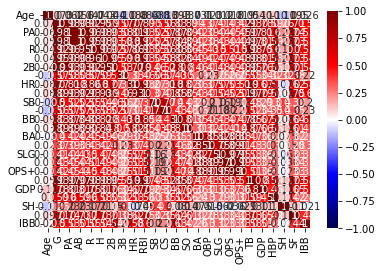

In [6]:
sns.heatmap(master_list.corr(), cmap="seismic", annot=True, vmin=-1, vmax=1);

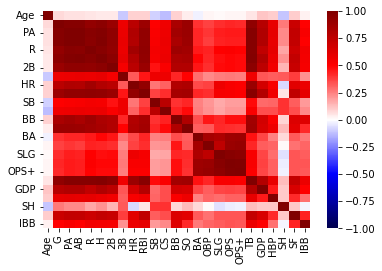

In [7]:
sns.heatmap(master_list.corr(), cmap="seismic", annot=False, vmin=-1, vmax=1);

Text(0.5, 1.0, 'Player Batting Stats Heat Map')

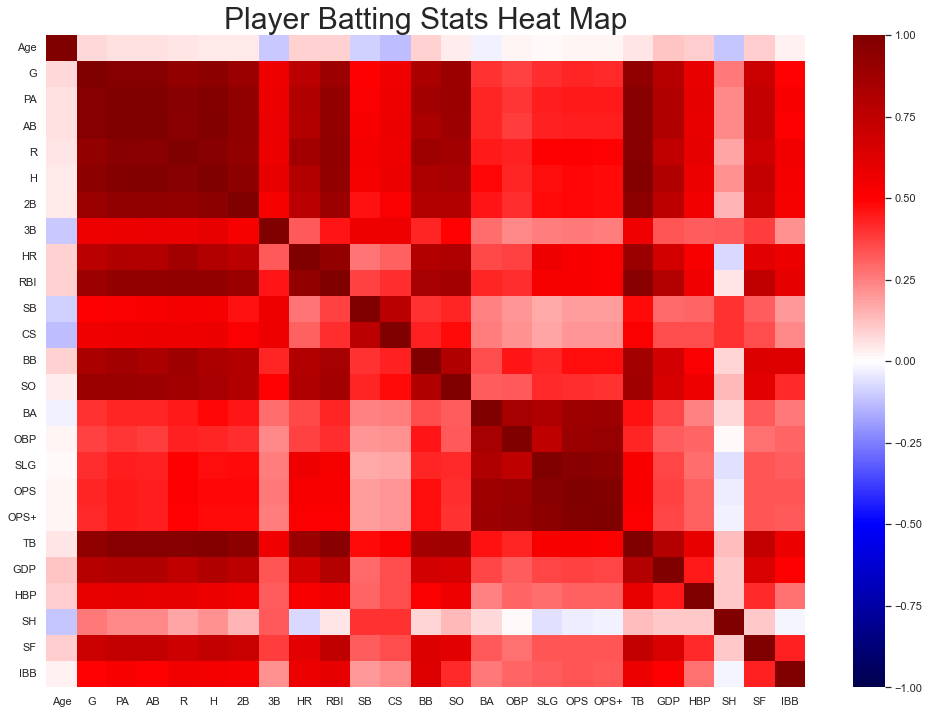

In [28]:
sns.set(rc = {'figure.figsize':(17,12)})
master_heatmap = sns.heatmap(master_list.corr(), cmap="seismic", annot=False, vmin=-1, vmax=1)

master_heatmap.set_title('Player Batting Stats Heat Map',fontsize = 30)

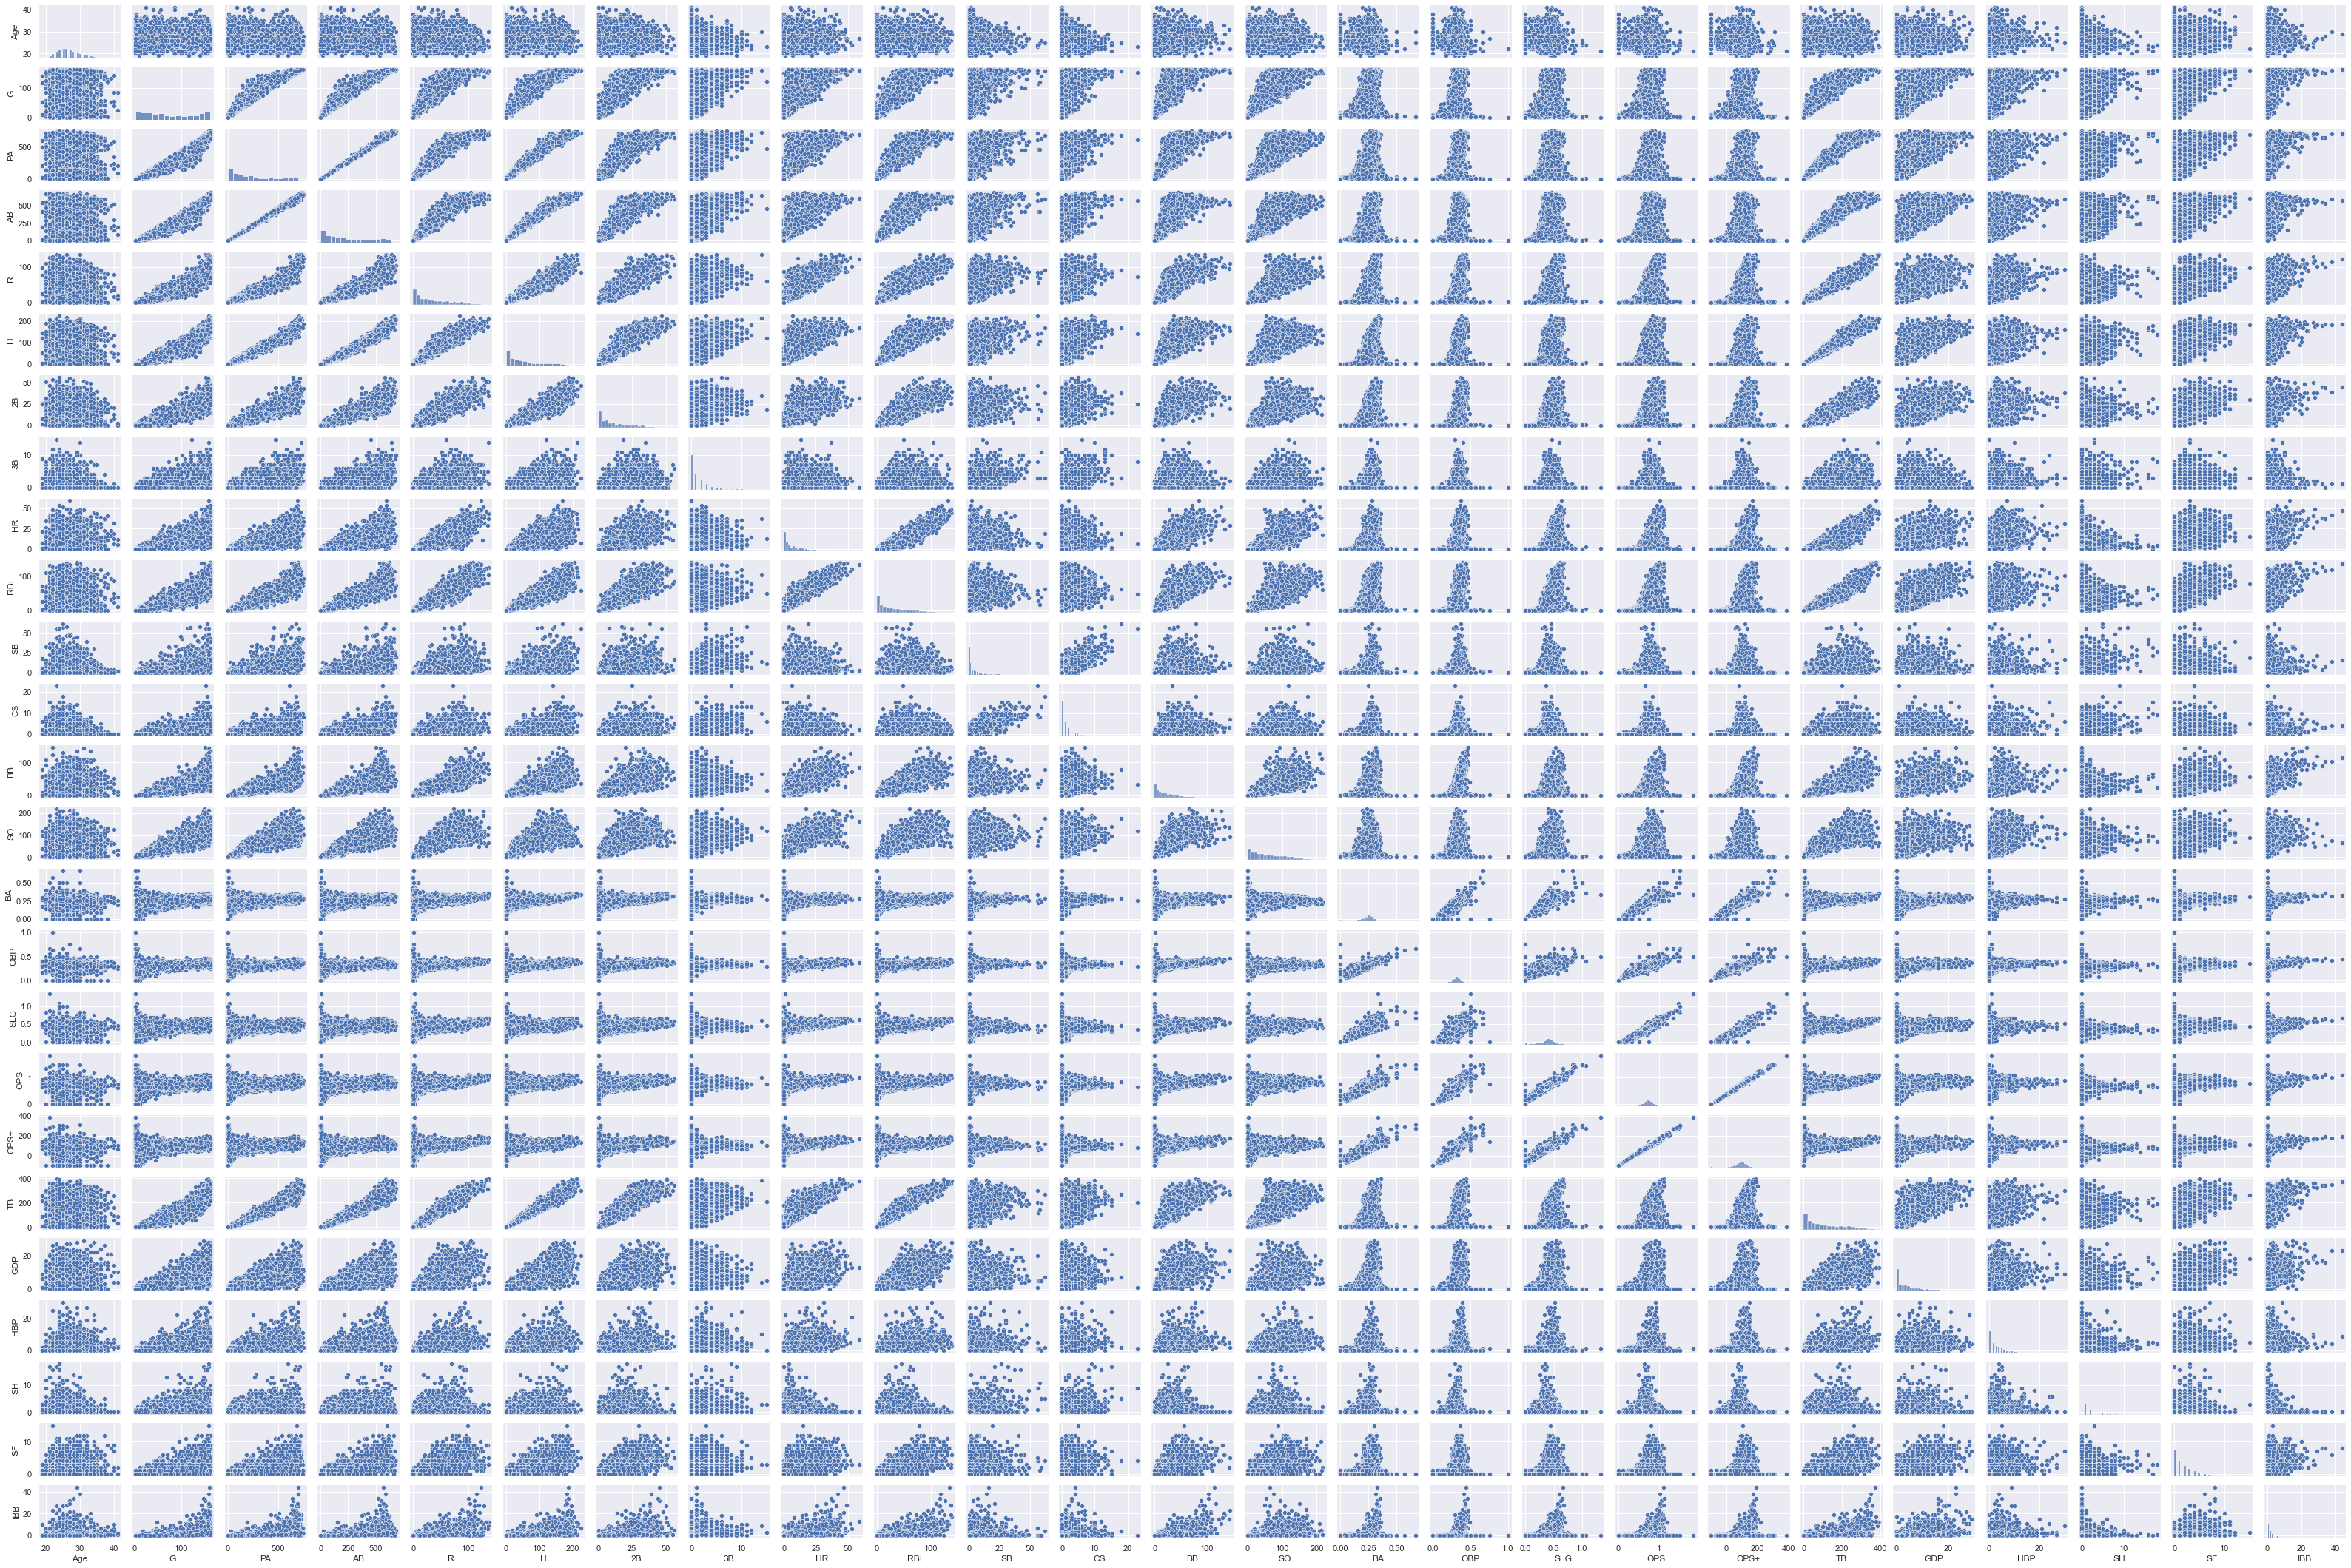

In [29]:
master_pairplot = sns.pairplot(master_list, height=1.2, aspect=1.5);

In [8]:
# drop G, AB, OPS+, and TB
# rename 2B and 3B

curated_list = master_list.copy()
curated_list.drop(['G', 'AB','TB','OPS+'], axis=1, inplace=True)
curated_list =curated_list.rename(columns={"2B": "Db", "3B": "Tp"})


Text(0.5, 1.0, 'Strong Corrolation with R, RBI, BB, SO, GDP')

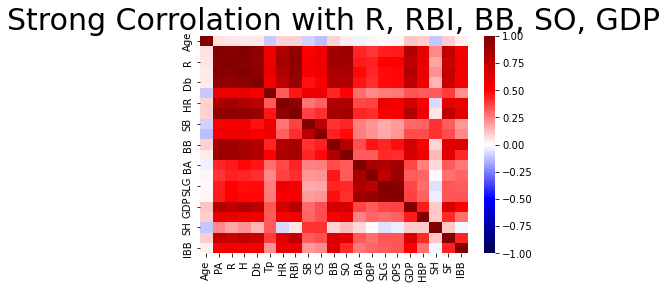

In [9]:
curated_heatmap = sns.heatmap(curated_list.corr(), cmap="seismic", annot=False, vmin=-1, vmax=1)
curated_heatmap.set_title('Strong Corrolation with R, RBI, BB, SO, GDP',fontsize = 30)

In [10]:
curated_list.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3365 entries, 0 to 3364
Data columns (total 21 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Age     3365 non-null   int64  
 1   PA      3365 non-null   int64  
 2   R       3365 non-null   int64  
 3   H       3365 non-null   int64  
 4   Db      3365 non-null   int64  
 5   Tp      3365 non-null   int64  
 6   HR      3365 non-null   int64  
 7   RBI     3365 non-null   int64  
 8   SB      3365 non-null   int64  
 9   CS      3365 non-null   int64  
 10  BB      3365 non-null   int64  
 11  SO      3365 non-null   int64  
 12  BA      3357 non-null   float64
 13  OBP     3358 non-null   float64
 14  SLG     3357 non-null   float64
 15  OPS     3357 non-null   float64
 16  GDP     3365 non-null   int64  
 17  HBP     3365 non-null   int64  
 18  SH      3365 non-null   int64  
 19  SF      3365 non-null   int64  
 20  IBB     3365 non-null   int64  
dtypes: float64(4), int64(17)
memory usage

In [11]:

y, X = patsy.dmatrices('HR ~ PA + R + H + Db + Tp + Age + RBI + SB + CS + BB + SO + BA + OBP + SLG + OPS + GDP + HBP + SH + SF + IBB',
                       data=curated_list, return_type="dataframe")


# Create your model
model = sm.OLS(y, X)

# Fit your model to your training set
fit = model.fit()

# Print summary statistics of the model's performance
fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                     HR   R-squared:                       0.945
Model:                            OLS   Adj. R-squared:                  0.945
Method:                 Least Squares   F-statistic:                     2887.
Date:                Fri, 25 Feb 2022   Prob (F-statistic):               0.00
Time:                        05:23:27   Log-Likelihood:                -7675.2
No. Observations:                3357   AIC:                         1.539e+04
Df Residuals:                    3336   BIC:                         1.552e+04
Df Model:                          20                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.1398      0.393      0.356      0.722      -0.631       0.910
PA            -0.0118      0.002     -6.345      0.000      -0.015      -0.008
R              0.2177      0.007     30.319      0.000       0.204       0.232
H             -0.0291      0.007     -4.159      0.000      -0.043      -0.015
Db            -0.1806      0.011    -16.152      0.000      -0.203      -0.159
Tp            -0.4665      0.030    -15.319      0.000      -0.526      -0.407
Age           -0.0092      0.013     -0.724      0.469      -0.034       0.016
RBI            0.2812      0.006     49.808      0.000       0.270       0.292
SB            -0.0789      0.010     -7.829      0.000      -0.099      -0.059
CS             0.0216      0.031      0.696      0.486      -0.039       0.082
BB            -0.0269      0.006     -4.854      0.000      -0.038      -0.016
SO             0.0412      0.003     15.564      0.000       0.036       0.046
BA           -21.0717      1.714    -12.295      0.000     -24.432     -17.711
OBP           29.6819     87.380      0.340      0.734    -141.642     201.006
SLG           49.9143     87.392      0.571      0.568    -121.433     221.262
OPS          -33.9707     87.376     -0.389      0.697    -205.287     137.346
GDP           -0.0455      0.015     -3.058      0.002      -0.075      -0.016
HBP            0.0124      0.016      0.787      0.432      -0.018       0.043
SH            -0.2676      0.029     -9.255      0.000      -0.324      -0.211
SF            -0.2869      0.030     -9.592      0.000      -0.346      -0.228
IBB            0.1496      0.018      8.117      0.000       0.113       0.186
==============================================================================
Omnibus:                      229.430   Durbin-Watson:                   1.657
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1104.770
Skew:                           0.074   Prob(JB):                    1.27e-240
Kurtosis:                       5.806   Cond. No.                     1.41e+06
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.41e+06. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [12]:
# cutting highest P-values model based on full set (OBP, SLG, OPS, CS)

y, X = patsy.dmatrices('HR ~ PA + R + H + Db + Tp + Age + RBI + SB + BB + SO + BA + GDP + HBP + SH + SF + IBB',
                       data=curated_list, return_type="dataframe")

# Create your model
model2 = sm.OLS(y, X)

# Fit your model to your training set
fit2 = model2.fit()

# Print summary statistics of the model's performance
fit2.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                     HR   R-squared:                       0.937
Model:                            OLS   Adj. R-squared:                  0.937
Method:                 Least Squares   F-statistic:                     3105.
Date:                Fri, 25 Feb 2022   Prob (F-statistic):               0.00
Time:                        05:24:48   Log-Likelihood:                -7914.7
No. Observations:                3357   AIC:                         1.586e+04
Df Residuals:                    3340   BIC:                         1.597e+04
Df Model:                          16                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.1852      0.409     -0.453      0.651      -0.987       0.616
PA            -0.0132      0.002     -6.643      0.000      -0.017      -0.009
R              0.2476      0.008     32.715      0.000       0.233       0.262
H             -0.0620      0.007     -8.462      0.000      -0.076      -0.048
Db            -0.1519      0.012    -12.740      0.000      -0.175      -0.129
Tp            -0.4080      0.032    -12.567      0.000      -0.472      -0.344
Age           -0.0041      0.013     -0.305      0.760      -0.031       0.022
RBI            0.3247      0.006     57.586      0.000       0.314       0.336
SB            -0.0817      0.009     -8.965      0.000      -0.100      -0.064
BB            -0.0399      0.005     -7.373      0.000      -0.050      -0.029
SO             0.0472      0.003     16.710      0.000       0.042       0.053
BA            -0.6507      0.817     -0.796      0.426      -2.253       0.952
GDP           -0.0462      0.016     -2.897      0.004      -0.078      -0.015
HBP            0.0038      0.017      0.227      0.820      -0.029       0.036
SH            -0.2958      0.031     -9.575      0.000      -0.356      -0.235
SF            -0.3489      0.032    -10.928      0.000      -0.412      -0.286
IBB            0.1500      0.020      7.594      0.000       0.111       0.189
==============================================================================
Omnibus:                      246.297   Durbin-Watson:                   1.598
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1295.947
Skew:                           0.053   Prob(JB):                    3.88e-282
Kurtosis:                       6.042   Cond. No.                     7.33e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 7.33e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

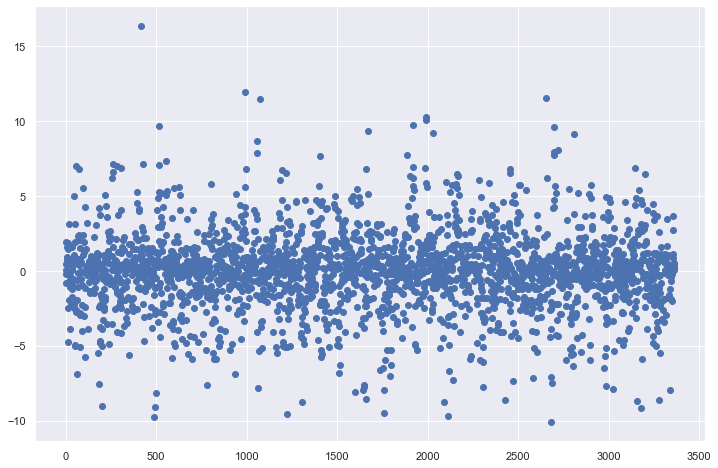

In [88]:
# Use statsmodels to plot the residuals
fit2.resid.plot(style='o', figsize=(12,8));

In [13]:
# cutting highest P-values model based on full set (OBP, SLG, OPS, CS, Age, HBP, BA)

y, X = patsy.dmatrices('HR ~ PA + R + H + Db + Tp + Age + RBI + SB + BB + SO + GDP + SH + SF + IBB',
                       data=curated_list, return_type="dataframe")

# Create your model
model3= sm.OLS(y, X)

# Fit your model to your training set
fit3 = model3.fit()

# Print summary statistics of the model's performance
fit3.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                     HR   R-squared:                       0.937
Model:                            OLS   Adj. R-squared:                  0.937
Method:                 Least Squares   F-statistic:                     3566.
Date:                Fri, 25 Feb 2022   Prob (F-statistic):               0.00
Time:                        05:27:14   Log-Likelihood:                -7930.0
No. Observations:                3365   AIC:                         1.589e+04
Df Residuals:                    3350   BIC:                         1.598e+04
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.3360      0.362     -0.928      0.354      -1.046       0.374
PA            -0.0127      0.002     -6.786      0.000      -0.016      -0.009
R              0.2481      0.007     33.391      0.000       0.234       0.263
H             -0.0642      0.007     -9.466      0.000      -0.077      -0.051
Db            -0.1519      0.012    -12.756      0.000      -0.175      -0.129
Tp            -0.4084      0.032    -12.609      0.000      -0.472      -0.345
Age           -0.0036      0.013     -0.265      0.791      -0.030       0.023
RBI            0.3246      0.006     57.666      0.000       0.314       0.336
SB            -0.0815      0.009     -8.969      0.000      -0.099      -0.064
BB            -0.0406      0.005     -7.629      0.000      -0.051      -0.030
SO             0.0470      0.003     16.711      0.000       0.042       0.053
GDP           -0.0461      0.016     -2.898      0.004      -0.077      -0.015
SH            -0.2969      0.031     -9.639      0.000      -0.357      -0.237
SF            -0.3494      0.032    -10.966      0.000      -0.412      -0.287
IBB            0.1511      0.020      7.683      0.000       0.113       0.190
==============================================================================
Omnibus:                      247.871   Durbin-Watson:                   1.598
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1309.640
Skew:                           0.054   Prob(JB):                    4.12e-285
Kurtosis:                       6.054   Cond. No.                     3.15e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.15e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

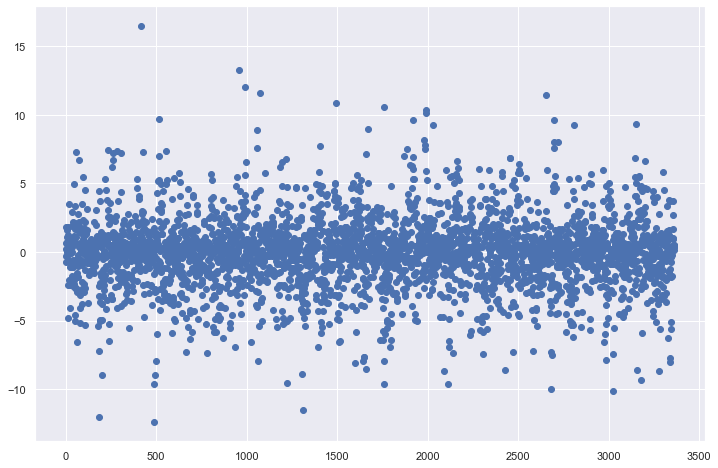

In [56]:
# Use statsmodels to plot the residuals
fit3.resid.plot(style='o', figsize=(12,8));

In [90]:
training_set.corr()['HR'].sort_values(ascending=False)

HR     1.000000
RBI    0.929132
R      0.866307
SO     0.811360
PA     0.811338
BB     0.801743
H      0.801109
Db     0.775338
GDP    0.661254
SF     0.617658
IBB    0.590819
SLG    0.564129
OPS    0.532928
HBP    0.518657
OBP    0.377021
BA     0.362836
Tp     0.332987
CS     0.305906
SB     0.250483
Age    0.076368
SH    -0.071865
Name: HR, dtype: float64

In [99]:
# splitting dataset into 3 groups
HomeRuns = curated_list.loc[:,'HR']
Variables = curated_list.copy()
Variables.drop(['HR'], axis=1, inplace=True)

Variables2 = Variables.copy()
Variables2.drop(['OBP','SLG','OPS','CS','HBP','BA'], axis=1, inplace=True)

X_train, X_VT, y_train, y_VT = train_test_split(Variables2, HomeRuns, test_size=0.2,random_state=5)
X_test, X_val, y_test, y_val = train_test_split(X_VT, y_VT, test_size=0.5,random_state=10)

In [85]:
y_val.head()

1801     0
1591    10
170     12
594      1
1152     1
Name: HR, dtype: int64

In [86]:
# basic linear model

model = LinearRegression()
model.fit(X_train, y_train)
print(model.score(X_train, y_train))
print(model.score(X_test, y_test))


0.9371399224171741
0.9367902776689996


In [87]:
list(zip(X_train.columns, model.coef_))

[('Age', -0.010263440256411599),
 ('PA', -0.011309303040666414),
 ('R', 0.24471951198246422),
 ('H', -0.0631499229205978),
 ('Db', -0.16767829179868526),
 ('Tp', -0.45213033091700633),
 ('RBI', 0.32166333824549354),
 ('SB', -0.08953644118767425),
 ('BB', -0.036316313869324005),
 ('SO', 0.04597563696685249),
 ('GDP', -0.03749871976784187),
 ('SH', -0.283596957975385),
 ('SF', -0.3613931394679822),
 ('IBB', 0.16092500021849904)]

In [100]:
# Using standard scaler to account for variation
std = StandardScaler()
std.fit(X_train.values)
X_train_scale = std.transform(X_train.values)
X_test_scale = std.transform(X_test.values)
X_val_scale = std.transform(X_val.values)

In [101]:
# Ridge model and testing

lr_model_ridge = Ridge(alpha = 500)
lr_model_ridge.fit(X_train_scale, y_train)
ridge_test_r2 = lr_model_ridge.score(X_test_scale, y_test)

In [102]:
print(lr_model_ridge.score(X_train_scale, y_train))
print(lr_model_ridge.score(X_test_scale, y_test))

0.879701019694989
0.8738661674150796


In [103]:
print(lr_model_ridge.score(X_train_scale, y_train))
print(lr_model_ridge.score(X_test_scale, y_test))

0.879701019694989
0.8738661674150796


In [104]:
list(zip(X_train.columns, lr_model_ridge.coef_))

[('Age', -0.018385895405220433),
 ('PA', 0.35458045476497657),
 ('R', 2.40924281085347),
 ('H', 0.33870231325497246),
 ('Db', -0.20600027356083672),
 ('Tp', -0.7840638539420896),
 ('RBI', 3.9308229760256763),
 ('SB', -0.6653874696552267),
 ('BB', 0.8475432886987561),
 ('SO', 2.1016679261893514),
 ('GDP', -0.14822924330395115),
 ('SH', -1.05835243302482),
 ('SF', -0.1792667233559826),
 ('IBB', 0.6645070005596427)]

In [105]:
alphas = 10**np.linspace(-2,2,200)
ridge_model = RidgeCV(alphas = alphas, cv=5)
ridge_model.fit(X_train_scale, y_train)
ridge_model.score(X_train_scale, y_train)
ridge_test_lamba = ridge_model.score(X_test_scale, y_test)
print(ridge_test_lamba)

0.9367453261458971


In [106]:
list(zip(X_train.columns, lr_model_ridge.coef_))

[('Age', -0.018385895405220433),
 ('PA', 0.35458045476497657),
 ('R', 2.40924281085347),
 ('H', 0.33870231325497246),
 ('Db', -0.20600027356083672),
 ('Tp', -0.7840638539420896),
 ('RBI', 3.9308229760256763),
 ('SB', -0.6653874696552267),
 ('BB', 0.8475432886987561),
 ('SO', 2.1016679261893514),
 ('GDP', -0.14822924330395115),
 ('SH', -1.05835243302482),
 ('SF', -0.1792667233559826),
 ('IBB', 0.6645070005596427)]

In [107]:
alpha = ridge_model.alpha_

In [108]:
alpha

0.8504489341802677

In [109]:
# lasso regression and testing
lasso = Lasso(alpha = 100)
lasso.fit(X_train_scale, y_train)
test_r_squared = lasso.score(X_test_scale, y_test)
print(test_r_squared)

-0.0011820813241434358


In [111]:
alphas = 10**np.linspace(-2,2,200)
lasso_model = LassoCV(alphas = alphas, cv=5)
lasso_model.fit(X_train_scale, y_train)
r_squared_train = lasso_model.score(X_train_scale, y_train)
r_squared_test = lasso_model.score(X_test_scale, y_test)
r_squared_val = lasso_model.score(X_val_scale, y_val)
alpha = lasso_model.alpha_

In [112]:
print("r_squared_train: ", round(r_squared_train, 3))
print("r_squared_test: ", round(r_squared_test, 3))
print("r_squared_val: ", round(r_squared_val, 3))

r_squared_train:  0.937
r_squared_test:  0.937
r_squared_val:  0.935


In [30]:
alpha

0.01

Computing regularization path using the LARS ...


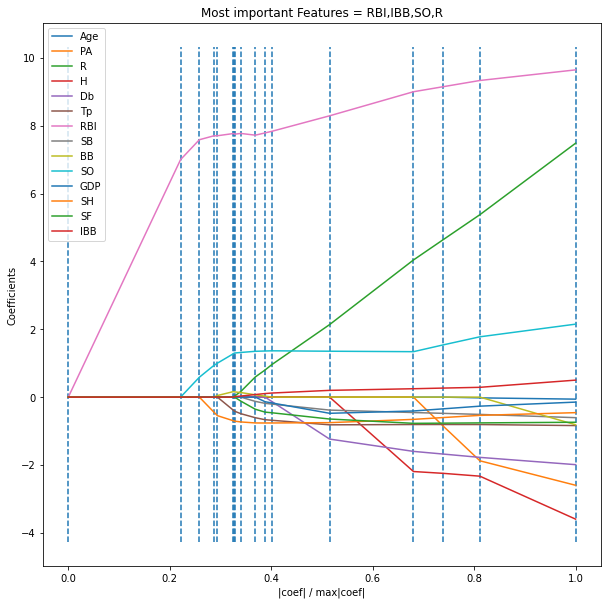

In [79]:
from sklearn.linear_model import lars_path
import matplotlib.pyplot as plt

alphas = 10**np.linspace(-2,2,200)

print("Computing regularization path using the LARS ...")
alphas, _, coefs = lars_path(X_train_scale, y_train.values, method='lasso')

# plotting the LARS path

xx = np.sum(np.abs(coefs.T), axis=1)
xx /= xx[-1]

plt.figure(figsize=(10,10))
plt.plot(xx, coefs.T)
ymin, ymax = plt.ylim()
plt.vlines(xx, ymin, ymax, linestyle='dashed')
plt.xlabel('|coef| / max|coef|')
plt.ylabel('Coefficients')
plt.title('Most important Features = RBI,IBB,SO,R')
plt.axis('tight')
plt.legend(X_train.columns)
plt.show()

In [32]:
# Elastic net model regression and testing

In [115]:
enet = ElasticNet(alpha = 1, l1_ratio=.5)
alphas = 10**np.linspace(-2,2,200)
enet_model = ElasticNetCV(l1_ratio = [0.1, 0.5, 0.7, 0.9, 0.95, 0.99, 1], 
                          alphas = alphas, 
                          cv=5,
                          random_state=16)

enet_model.fit(X_train_scale, y_train)
r_squared_train = enet_model.score(X_train_scale, y_train)
r_squared_test = enet_model.score(X_test_scale, y_test)
r_squared_val = enet_model.score(X_val_scale, y_val)
alpha = lasso_model.alpha_
l1_ratio = enet_model.l1_ratio_

In [114]:
print("r_squared_train: ", round(r_squared_train, 3))
print("r_squared_test: ", round(r_squared_test, 3))
print("r_squared_val: ", round(r_squared_val, 3))
print("alpha: ", round(alpha, 3))
print("l1_ratio: ", l1_ratio)

r_squared_train:  0.937
r_squared_test:  0.937
r_squared_val:  0.935
alpha:  0.01
l1_ratio:  1.0


In [52]:
'''
# create model based on full set, dependant age
# almost no corrolation

y, X = patsy.dmatrices('Age ~ PA + R + H + Db + Tp + HR + RBI + SB + CS + BB + SO + BA + OBP + SLG + OPS + GDP + HBP + SH + SF + IBB',
                       data=training_set, return_type="dataframe")


# Create your model
model = sm.OLS(y, X)

# Fit your model to your training set
fit = model.fit()

# Print summary statistics of the model's performance
fit.summary()
'''

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    Age   R-squared:                       0.093
Model:                            OLS   Adj. R-squared:                  0.088
Method:                 Least Squares   F-statistic:                     17.12
Date:                Fri, 25 Feb 2022   Prob (F-statistic):           2.69e-57
Time:                        02:20:06   Log-Likelihood:                -8723.6
No. Observations:                3357   AIC:                         1.749e+04
Df Residuals:                    3336   BIC:                         1.762e+04
Df Model:                          20                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     26.3584      0.283     93.102      0.000      25.803      26.913
PA             0.0129      0.003      5.050      0.000       0.008       0.018
R             -0.0096      0.011     -0.866      0.387      -0.031       0.012
H             -0.0230      0.010     -2.398      0.017      -0.042      -0.004
Db            -0.0317      0.016     -2.001      0.046      -0.063      -0.001
Tp            -0.2031      0.043     -4.733      0.000      -0.287      -0.119
HR            -0.0171      0.024     -0.724      0.469      -0.064       0.029
RBI            0.0112      0.010      1.103      0.270      -0.009       0.031
SB             0.0255      0.014      1.838      0.066      -0.002       0.053
CS            -0.2606      0.042     -6.190      0.000      -0.343      -0.178
BB             0.0093      0.008      1.223      0.221      -0.006       0.024
SO            -0.0215      0.004     -5.787      0.000      -0.029      -0.014
BA            -8.8891      2.390     -3.720      0.000     -13.574      -4.204
OBP          -66.1696    119.406     -0.554      0.580    -300.285     167.946
SLG          -69.4780    119.425     -0.582      0.561    -303.632     164.676
OPS           71.0672    119.401      0.595      0.552    -163.039     305.173
GDP            0.0436      0.020      2.142      0.032       0.004       0.084
HBP            0.0850      0.021      3.971      0.000       0.043       0.127
SH            -0.1701      0.040     -4.263      0.000      -0.248      -0.092
SF             0.0648      0.041      1.564      0.118      -0.016       0.146
IBB           -0.0914      0.025     -3.599      0.000      -0.141      -0.042
==============================================================================
Omnibus:                      174.824   Durbin-Watson:                   0.640
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              202.453
Skew:                           0.577   Prob(JB):                     1.09e-44
Kurtosis:                       3.343   Cond. No.                     1.41e+06
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.41e+06. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [ ]:
"""
# checks player eligibility and tracks avg salary and contract start

eligible = []
contract_list = []
salary_list = []

for index, batter in player_list.iterrows():
    res = requests.get(batter['URL'])
    page = res.text
    soup = bs(page)
    meta = soup.find('div', id='meta').text
    time.sleep(3)
    
    position_loc = meta.find('Position')
    position = meta[position_loc+13:position_loc+25]
    
    contract_loc = meta.find('2022 Contract Status')
    
    if position.find('itcher') == -1:
        pos_result = True
    else:
        eligible.append(False)
        contract_list.append(0)
        salary_list.append(0)
        continue
        
    contract_loc = meta.find('2022 Contract Status')
    contract = meta[contract_loc:contract_loc+64]
    
    if contract.find('Signed') == -1:
        eligible.append(False)
        contract_list.append(0)
        salary_list.append(0)
        continue
    else:
        eligible_player = True

    con_end = contract_loc+63
    contract = meta[contract_loc:contract_loc+64]
    
    
    listed =  re.findall('\w+',contract)
    origin_list = [i for i, elem in enumerate(listed) if 'yr' in elem]
    origin = origin_list[0]
    
    length = int(listed[origin-1])
    if 'M' in listed[origin+1]:
        total = int(listed[origin+1].replace('M',''))
        con_start = '20'+ listed[origin+2]
        con_start = int(con_start)
    else:
        total = listed[origin+1]+'.'+listed[origin+2]
        total = total.replace('M','')
        total = float(total)
        con_start = '20'+ listed[origin+3]
        con_start = int(con_start)
    
    avg = total/length
    
    eligible.append(eligible_player)
    contract_list.append(con_start)
    salary_list.append(avg)
    

player_list['Eligible'], player_list['Contract'], player_list['Salary'] =  eligible, contract_list, salary_list
signed_list = player_list.loc[player_list['Eligible'], :]

signed_list.to_csv('signed.csv', index=False)

"""

In [6]:
'''
# drop career totals, drop str columns, and convert data to int and float

for player in batter_dic:
    year = batter_dic[player]['Year'].where(batter_dic[player]['Year']=='2021').last_valid_index()
    batter_dic[player].drop(batter_dic[player].index[year+1:], inplace=True)
    batter_dic[player].drop(['Tm','Lg','Pos','Awards'], axis=1, inplace=True)
    
    for col in batter_dic[player]:
        batter_dic[player][col] = pd.to_numeric(batter_dic[player][col], errors='ignore')
        
    batter_dic[player]= batter_dic[player].fillna(0)
    
# change original csv to having numeric types

batter_csv['Year'] = pd.to_numeric(batter_csv['Year'], errors='ignore')
batter_csv['Salary'] = pd.to_numeric(batter_csv['Salary'], errors='ignore')

'''

In [12]:
'''
# find range of important contract years
player_years = []
for player,row in batter_csv.iterrows():
    my_set = []
    year = batter_csv['Year'][player]
    first_year = year-3
    batter = batter_csv['Player'][player]
    first_year_row = batter_dic[batter]['Year'].where(batter_dic[batter]['Year']==first_year).first_valid_index()
    last_year_row = batter_dic[batter]['Year'].where(batter_dic[batter]['Year']==year).last_valid_index()
    
    my_set.append(first_year_row)
    my_set.append(last_year_row)
    player_years.append(my_set)
    
'''

In [11]:
'''
# get rid of years outside range
count = 0

for player in batter_dic:
    
    batter_dic[player].drop(batter_dic[player].index[player_years[count][1]:], inplace=True)
    batter_dic[player].drop(batter_dic[player].index[0:player_years[count][0]], inplace=True)
    count += 1
'''

[[14, 17], [2, 6], [8, 12]]


In [ ]:
'''
#  add primary variables
total_columns = ['G', 'PA','AB','R','H','2B','3B','HR','RBI','SB', 'CS','BB','SO','TB','GDP','HBP','SH','SF','IBB']
avg_columns = ['BA','OBP', 'SLG', 'OPS','OPS+']

for column in total_columns:
    my_set = []
    for player in batter_dic:
        my_set.append(batter_dic[player][column].sum())
    batter_csv[column] = my_set
for column in avg_columns:
    my_set = []
    for player in batter_dic:
        my_set.append(batter_dic[player][column].mean())
    batter_csv[column] = my_set
    
age_set = []

for player in batter_dic:
    batter_dic[player] = batter_dic[player].reset_index()
    age_set.append(batter_dic[player]['Age'][0])

batter_csv['Age'] = age_set

'''